# Import Required Libraries

In [6]:
# Required libraries are imported.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import random
from torchvision import datasets
from torch.utils.data import DataLoader, Subset

# Define Dataset Path and Transformations

In [7]:
from torchvision import transforms

# The dataset path is defined.
dataset_path = "/Users/tahfimibnkhan/Desktop/DATASET/FINAL/AUGMENTED_DATA(without random erasing)"

# Transformations are applied to the images.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loading the Dataset

In [8]:
# The dataset is loaded using ImageFolder.
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# The number of classes in the dataset is obtained.
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 7


# Splitting the Dataset into Training and Validation Sets 85-15

In [9]:
from torch.utils.data import random_split, DataLoader

total_size = len(dataset)

train_size = round(0.70 * total_size)
val_size = round(0.20 * total_size)
test_size = total_size - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size],generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 3430
Validation samples: 980
Test samples: 490


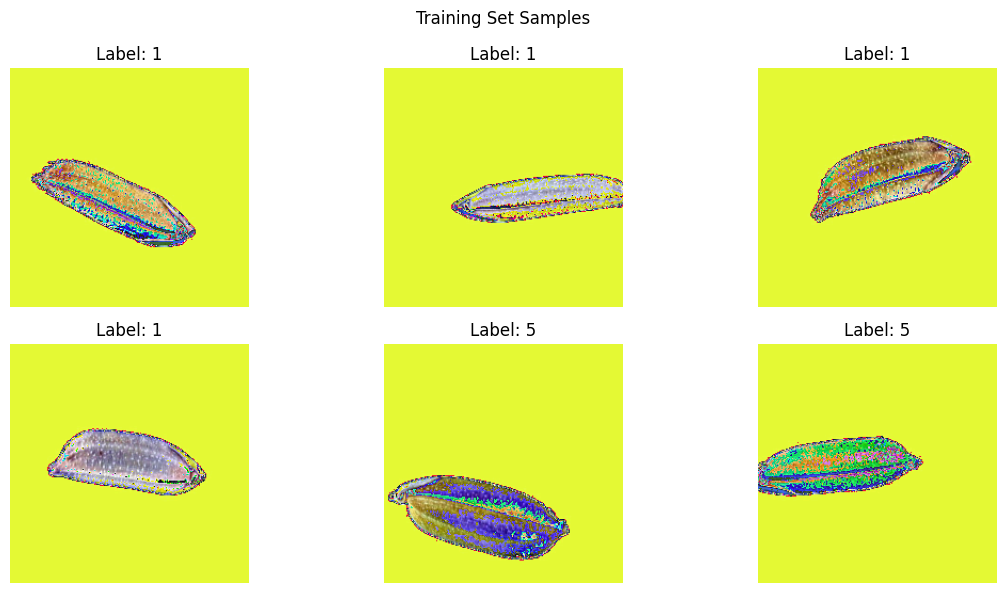

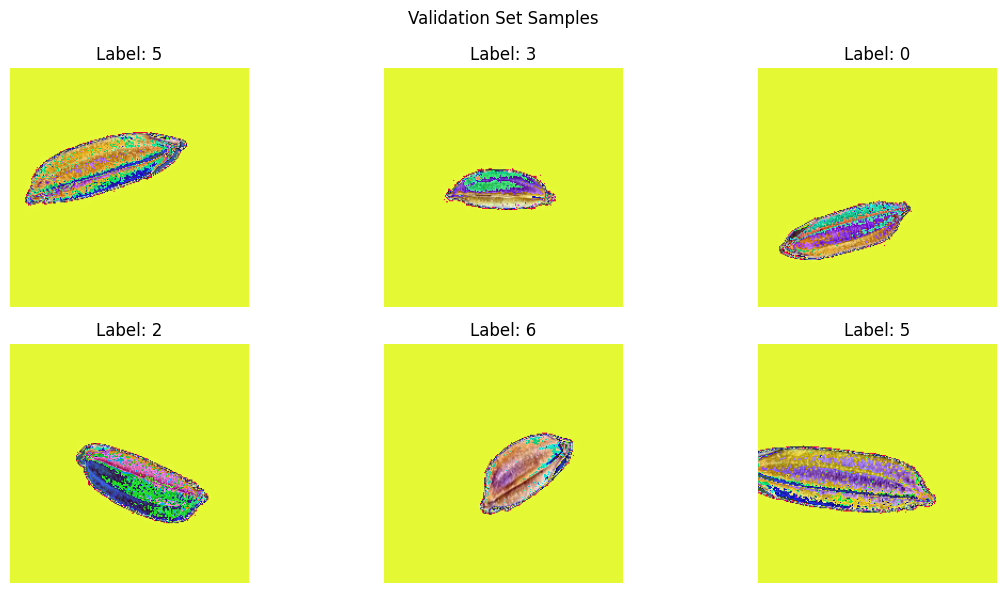

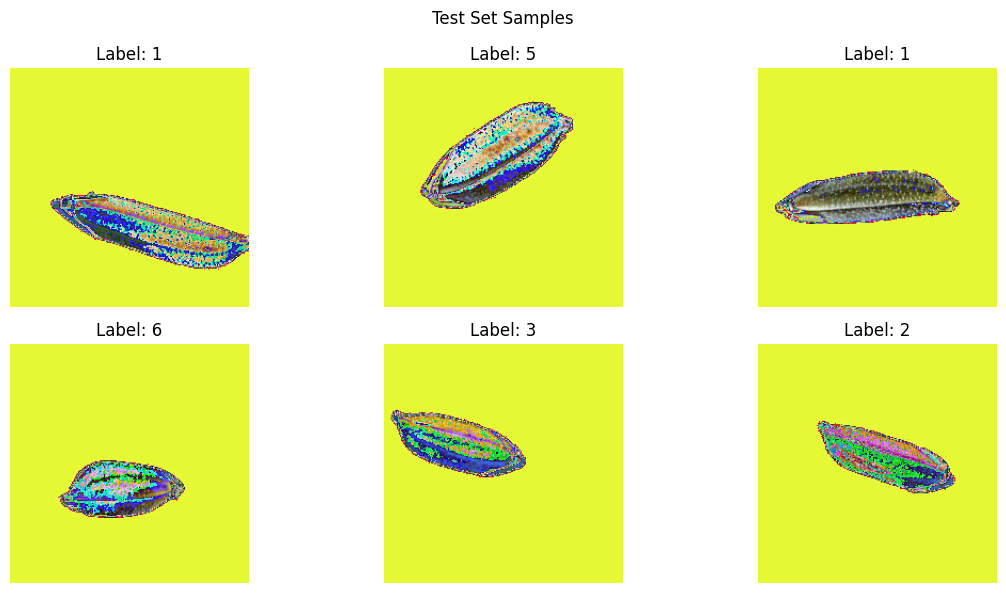

In [10]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show_images_from_loader(data_loader, title, num_images=6):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        img = F.to_pil_image(images[i])  # Convert tensor to PIL Image
        plt.imshow(img)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_images_from_loader(train_loader, "Training Set Samples")
show_images_from_loader(val_loader, "Validation Set Samples")
show_images_from_loader(test_loader, "Test Set Samples")

In [11]:
import os
import json
import time
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, f1_score, roc_auc_score, roc_curve, auc,
    precision_recall_fscore_support, matthews_corrcoef, cohen_kappa_score,
    precision_recall_curve
)
from sklearn.preprocessing import label_binarize


def plotting(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Training Loss", marker="o", linestyle="-", color="blue")
    plt.plot(history["val_loss"], label="Validation Loss", marker="s", linestyle="-", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Training Accuracy", marker="o", linestyle="-", color="green")
    plt.plot(history["val_acc"], label="Validation Accuracy", marker="s", linestyle="-", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


def evaluate_model(model, dataloader, class_names=dataset.classes, top_k=(1, 5), loader_name="Validation", model_name="Model"):
    print(f"\n========== Evaluating {model_name} on {loader_name} Set ==========\n")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    top_k_correct = {k: 0 for k in top_k}
    total_samples = 0
    start_time = time.time()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            top_k_preds = torch.topk(outputs, max(top_k), dim=1).indices.cpu().numpy()

            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for k in top_k:
                top_k_correct[k] += np.sum(labels.cpu().numpy()[:, None] == top_k_preds[:, :k])
            total_samples += labels.size(0)

    inference_time = time.time() - start_time
    avg_inference_time = inference_time / total_samples

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds)
    accuracy = np.trace(cm) / np.sum(cm) * 100
    error_rate = 100 - accuracy
    precision = np.diag(cm) / np.where(np.sum(cm, axis=0) == 0, 1, np.sum(cm, axis=0)) * 100
    recall = np.diag(cm) / np.where(np.sum(cm, axis=1) == 0, 1, np.sum(cm, axis=1)) * 100
    tn = np.sum(cm) - (np.sum(cm, axis=1) + np.sum(cm, axis=0) - np.diag(cm))
    fp = np.sum(cm, axis=0) - np.diag(cm)
    specificity = tn / np.where((tn + fp) == 0, 1, (tn + fp)) * 100

    f1_macro = f1_score(all_labels, all_preds, average="macro") * 100
    f1_weighted = f1_score(all_labels, all_preds, average="weighted") * 100
    f1_per_class = f1_score(all_labels, all_preds, average=None) * 100
    mcc = matthews_corrcoef(all_labels, all_preds) * 100
    kappa = cohen_kappa_score(all_labels, all_preds) * 100

    n_classes = len(class_names) if class_names is not None else np.max(all_labels) + 1
    if class_names is None:
        class_names = [str(i) for i in range(n_classes)]

    if n_classes > 1:
        all_labels_binarized = label_binarize(all_labels, classes=np.arange(n_classes))
        roc_auc = roc_auc_score(all_labels_binarized, all_probs, multi_class="ovr") * 100
    else:
        roc_auc = None

    top_k_accuracy = {f"Top-{k} Accuracy (%)": (top_k_correct[k] / total_samples) * 100 for k in top_k}

    unique_classes, support = np.unique(all_labels, return_counts=True)
    support_df = pd.DataFrame({
        "Class": class_names,
        "Support (Samples)": support
    })

    metrics_df = pd.DataFrame({
        "Class": class_names,
        "Precision (%)": precision,
        "Recall (%)": recall,
        "F1-Score (%)": f1_per_class,
        "Specificity (%)": specificity
    }).round(2)

    print(f"\nOverall Accuracy: {accuracy:.2f}%")
    print(f"Overall Error Rate: {error_rate:.2f}%")
    print(f"F1-Score (Macro-Averaged): {f1_macro:.2f}%")
    print(f"F1-Score (Weighted): {f1_weighted:.2f}%")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}%")
    print(f"Cohen’s Kappa Score: {kappa:.2f}%")
    for k, acc in top_k_accuracy.items():
        print(f"{k}: {acc:.2f}%")
    print(f"\nAverage Inference Time per Image: {avg_inference_time:.6f} seconds")
    print("\nClass-Wise Performance Metrics:")
    print(metrics_df.to_string(index=False))
    print("\nClass-Wise Sample Distribution:")
    print(support_df.to_string(index=False))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.tight_layout()
    plt.show()

    if roc_auc is not None:
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs[:, i])
            roc_auc_val = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc_val:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve: {model_name}")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(8, 6))
    for class_idx, class_name in enumerate(class_names):
        y_true = (all_labels == class_idx).astype(int)
        y_scores = (all_preds == class_idx).astype(int)
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall_curve, precision_curve)
        plt.plot(recall_curve, precision_curve, label=f"{class_name} (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve: {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "accuracy": round(accuracy, 2),
        "error_rate": round(error_rate, 2),
        "f1_macro": round(f1_macro, 2),
        "f1_weighted": round(f1_weighted, 2),
        "roc_auc": round(roc_auc, 2) if roc_auc is not None else "N/A",
        "mcc": round(mcc, 2),
        "kappa": round(kappa, 2),
        "top_k_accuracy": top_k_accuracy,
        "avg_inference_time": avg_inference_time,
        "class_metrics": metrics_df.to_dict(orient="records"),
        "class_support": support_df.to_dict(orient="records")
    }


def save_model_artifacts(
    model,
    history,
    metrics,
    model_name="model",
    version="V1",
    base_dir="/Users/tahfimibnkhan/Desktop/ViT_Final"
):
    """
    Saves model, training metrics, and evaluation metrics in a structured format.

    Args:
        model (torch.nn.Module): Trained model to save.
        history (dict): Training history with 'train_loss', 'train_acc', 'val_loss', 'val_acc'.
        metrics (dict): Evaluation metrics dictionary.
        model_name (str): Name of the model (e.g., "deit_small", "mobilevit", etc.).
        version (str): Version identifier (e.g., "V1", "V2").
        base_dir (str): Base directory to save all artifacts.
    """
    # Save training metrics
    logs_dir = os.path.join(base_dir, "RESULTS~~", "logs")
    os.makedirs(logs_dir, exist_ok=True)

    training_metrics = {
        "train_loss": history["train_loss"][-1],
        "train_acc": history["train_acc"][-1],
        "val_loss": history["val_loss"][-1],
        "val_acc": history["val_acc"][-1]
    }

    training_metrics_path = os.path.join(logs_dir, f"{model_name}_training_metrics_{version}.json")
    with open(training_metrics_path, "w") as f:
        json.dump(training_metrics, f, indent=4)
    print(f"Training metrics logged to {training_metrics_path}")

    # Save model
    model_dir = os.path.join(base_dir, "MODELS~~", model_name)
    os.makedirs(model_dir, exist_ok=True)
    model.to("cpu")
    model_path = os.path.join(model_dir, f"{model_name}_{version}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Save evaluation metrics
    eval_dir = os.path.join(base_dir, "RESULTS~~", "evaluation_logs")
    os.makedirs(eval_dir, exist_ok=True)

    eval_metrics_path = os.path.join(eval_dir, f"{model_name}_evaluation_metrics_{version}.json")
    with open(eval_metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)
    print(f"Evaluation metrics saved at: {eval_metrics_path}")

    # Save class-wise metrics
    class_metrics = metrics.get("Class-Wise Metrics") or metrics.get("class_metrics")
    if class_metrics:
        class_metrics_df = pd.DataFrame(class_metrics)
        class_metrics_path = os.path.join(eval_dir, f"{model_name}_class_wise_metrics_{version}.csv")
        class_metrics_df.to_csv(class_metrics_path, index=False)
        print(f"Class-wise metrics saved at: {class_metrics_path}")
    else:
        print("No class-wise metrics found in evaluation results.")

# Swin-Tiny

In [13]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim

# Load pretrained Swin-Tiny with appropriate output classes
model_Swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes)

for param in model_Swin.parameters():
    param.requires_grad = False

for param in model_Swin.patch_embed.parameters():
    param.requires_grad = True

for param in model_Swin.head.parameters():
    param.requires_grad = True

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_Swin.to(device)

print(f"Model loaded and moved to {device}")
print("Only patch embedding (input) and classification head (output) are trainable.")

Model loaded and moved to cpu
Only patch embedding (input) and classification head (output) are trainable.


# Defining Loss Function and Optimizer

In [15]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model_Swin.parameters(), lr=5e-4, weight_decay=0.05)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

# Defining the Training Loop

In [16]:
from tqdm import tqdm

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, patience=15):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_loss = float("inf")
    early_stop_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), "swin_tiny_best_model.pth")
            print("Model improved. Best checkpoint saved.")
        else:
            early_stop_counter += 1
            print(f"No improvement. Early stopping counter: {early_stop_counter}/{patience}")
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    return history
history_Swin = train(model_Swin, train_loader, val_loader, criterion, optimizer, scheduler, epochs=40, patience=40)

Epoch 1/40: 100%|███████████████████████████████| 54/54 [10:51<00:00, 12.06s/it]


Epoch 1/40: Train Loss: 1.4481, Train Acc: 50.26% | Val Loss: 0.9577, Val Acc: 74.18%
Model improved. Best checkpoint saved.


Epoch 2/40: 100%|███████████████████████████████| 54/54 [08:39<00:00,  9.63s/it]


Epoch 2/40: Train Loss: 0.8761, Train Acc: 73.79% | Val Loss: 0.7010, Val Acc: 78.98%
Model improved. Best checkpoint saved.


Epoch 3/40: 100%|███████████████████████████████| 54/54 [08:37<00:00,  9.59s/it]


Epoch 3/40: Train Loss: 0.6796, Train Acc: 79.42% | Val Loss: 0.5461, Val Acc: 84.39%
Model improved. Best checkpoint saved.


Epoch 4/40: 100%|███████████████████████████████| 54/54 [08:15<00:00,  9.17s/it]


Epoch 4/40: Train Loss: 0.5919, Train Acc: 81.63% | Val Loss: 0.4660, Val Acc: 85.51%
Model improved. Best checkpoint saved.


Epoch 5/40: 100%|███████████████████████████████| 54/54 [11:39<00:00, 12.95s/it]


Epoch 5/40: Train Loss: 0.4994, Train Acc: 84.43% | Val Loss: 0.4292, Val Acc: 86.02%
Model improved. Best checkpoint saved.


Epoch 6/40: 100%|███████████████████████████████| 54/54 [11:33<00:00, 12.85s/it]


Epoch 6/40: Train Loss: 0.4502, Train Acc: 85.86% | Val Loss: 0.4226, Val Acc: 85.51%
Model improved. Best checkpoint saved.


Epoch 7/40: 100%|███████████████████████████████| 54/54 [09:26<00:00, 10.49s/it]


Epoch 7/40: Train Loss: 0.4075, Train Acc: 87.43% | Val Loss: 0.3522, Val Acc: 88.67%
Model improved. Best checkpoint saved.


Epoch 8/40: 100%|███████████████████████████████| 54/54 [10:11<00:00, 11.32s/it]


Epoch 8/40: Train Loss: 0.3805, Train Acc: 87.64% | Val Loss: 0.3316, Val Acc: 89.39%
Model improved. Best checkpoint saved.


Epoch 9/40: 100%|███████████████████████████████| 54/54 [14:33<00:00, 16.18s/it]


Epoch 9/40: Train Loss: 0.3595, Train Acc: 88.78% | Val Loss: 0.3006, Val Acc: 89.69%
Model improved. Best checkpoint saved.


Epoch 10/40: 100%|██████████████████████████████| 54/54 [14:19<00:00, 15.92s/it]


Epoch 10/40: Train Loss: 0.3336, Train Acc: 89.68% | Val Loss: 0.3082, Val Acc: 89.08%
No improvement. Early stopping counter: 1/40


Epoch 11/40: 100%|██████████████████████████████| 54/54 [14:24<00:00, 16.00s/it]


Epoch 11/40: Train Loss: 0.3293, Train Acc: 90.17% | Val Loss: 0.2758, Val Acc: 89.39%
Model improved. Best checkpoint saved.


Epoch 12/40: 100%|██████████████████████████████| 54/54 [12:28<00:00, 13.87s/it]


Epoch 12/40: Train Loss: 0.2989, Train Acc: 90.76% | Val Loss: 0.2633, Val Acc: 91.43%
Model improved. Best checkpoint saved.


Epoch 13/40: 100%|██████████████████████████████| 54/54 [10:36<00:00, 11.80s/it]


Epoch 13/40: Train Loss: 0.2831, Train Acc: 91.57% | Val Loss: 0.2640, Val Acc: 91.02%
No improvement. Early stopping counter: 1/40


Epoch 14/40: 100%|██████████████████████████████| 54/54 [11:18<00:00, 12.57s/it]


Epoch 14/40: Train Loss: 0.2703, Train Acc: 91.49% | Val Loss: 0.2344, Val Acc: 91.73%
Model improved. Best checkpoint saved.


Epoch 15/40: 100%|██████████████████████████████| 54/54 [11:19<00:00, 12.58s/it]


Epoch 15/40: Train Loss: 0.2576, Train Acc: 91.78% | Val Loss: 0.2363, Val Acc: 92.14%
No improvement. Early stopping counter: 1/40


Epoch 16/40: 100%|██████████████████████████████| 54/54 [10:51<00:00, 12.07s/it]


Epoch 16/40: Train Loss: 0.2466, Train Acc: 92.39% | Val Loss: 0.2491, Val Acc: 90.92%
No improvement. Early stopping counter: 2/40


Epoch 17/40: 100%|██████████████████████████████| 54/54 [10:55<00:00, 12.15s/it]


Epoch 17/40: Train Loss: 0.2554, Train Acc: 92.42% | Val Loss: 0.2471, Val Acc: 90.92%
No improvement. Early stopping counter: 3/40


Epoch 18/40: 100%|██████████████████████████████| 54/54 [10:12<00:00, 11.34s/it]


Epoch 18/40: Train Loss: 0.2401, Train Acc: 92.71% | Val Loss: 0.2070, Val Acc: 93.16%
Model improved. Best checkpoint saved.


Epoch 19/40: 100%|██████████████████████████████| 54/54 [10:47<00:00, 11.99s/it]


Epoch 19/40: Train Loss: 0.2255, Train Acc: 93.29% | Val Loss: 0.2180, Val Acc: 92.76%
No improvement. Early stopping counter: 1/40


Epoch 20/40: 100%|██████████████████████████████| 54/54 [11:06<00:00, 12.35s/it]


Epoch 20/40: Train Loss: 0.2194, Train Acc: 93.09% | Val Loss: 0.2093, Val Acc: 91.33%
No improvement. Early stopping counter: 2/40


Epoch 21/40: 100%|██████████████████████████████| 54/54 [11:33<00:00, 12.85s/it]


Epoch 21/40: Train Loss: 0.2170, Train Acc: 93.24% | Val Loss: 0.2056, Val Acc: 92.96%
Model improved. Best checkpoint saved.


Epoch 22/40: 100%|██████████████████████████████| 54/54 [11:08<00:00, 12.37s/it]


Epoch 22/40: Train Loss: 0.2089, Train Acc: 93.79% | Val Loss: 0.2190, Val Acc: 91.84%
No improvement. Early stopping counter: 1/40


Epoch 23/40: 100%|██████████████████████████████| 54/54 [12:52<00:00, 14.31s/it]


Epoch 23/40: Train Loss: 0.2093, Train Acc: 93.56% | Val Loss: 0.2167, Val Acc: 92.45%
No improvement. Early stopping counter: 2/40


Epoch 24/40: 100%|██████████████████████████████| 54/54 [13:54<00:00, 15.45s/it]


Epoch 24/40: Train Loss: 0.2058, Train Acc: 94.11% | Val Loss: 0.1845, Val Acc: 93.27%
Model improved. Best checkpoint saved.


Epoch 25/40: 100%|██████████████████████████████| 54/54 [11:08<00:00, 12.38s/it]


Epoch 25/40: Train Loss: 0.1901, Train Acc: 93.99% | Val Loss: 0.1772, Val Acc: 93.98%
Model improved. Best checkpoint saved.


Epoch 26/40: 100%|██████████████████████████████| 54/54 [11:01<00:00, 12.24s/it]


Epoch 26/40: Train Loss: 0.1888, Train Acc: 94.55% | Val Loss: 0.1746, Val Acc: 93.78%
Model improved. Best checkpoint saved.


Epoch 27/40: 100%|██████████████████████████████| 54/54 [10:20<00:00, 11.50s/it]


Epoch 27/40: Train Loss: 0.1845, Train Acc: 94.43% | Val Loss: 0.1693, Val Acc: 94.08%
Model improved. Best checkpoint saved.


Epoch 28/40: 100%|██████████████████████████████| 54/54 [10:18<00:00, 11.46s/it]


Epoch 28/40: Train Loss: 0.1798, Train Acc: 94.69% | Val Loss: 0.1784, Val Acc: 94.08%
No improvement. Early stopping counter: 1/40


Epoch 29/40: 100%|██████████████████████████████| 54/54 [10:54<00:00, 12.13s/it]


Epoch 29/40: Train Loss: 0.1786, Train Acc: 94.69% | Val Loss: 0.1804, Val Acc: 93.78%
No improvement. Early stopping counter: 2/40


Epoch 30/40: 100%|██████████████████████████████| 54/54 [10:33<00:00, 11.74s/it]


Epoch 30/40: Train Loss: 0.1773, Train Acc: 94.72% | Val Loss: 0.1716, Val Acc: 93.67%
No improvement. Early stopping counter: 3/40


Epoch 31/40: 100%|██████████████████████████████| 54/54 [10:37<00:00, 11.80s/it]


Epoch 31/40: Train Loss: 0.1701, Train Acc: 95.42% | Val Loss: 0.1740, Val Acc: 94.18%
No improvement. Early stopping counter: 4/40


Epoch 32/40: 100%|██████████████████████████████| 54/54 [10:43<00:00, 11.91s/it]


Epoch 32/40: Train Loss: 0.1696, Train Acc: 95.04% | Val Loss: 0.1691, Val Acc: 93.98%
Model improved. Best checkpoint saved.


Epoch 33/40: 100%|██████████████████████████████| 54/54 [10:47<00:00, 12.00s/it]


Epoch 33/40: Train Loss: 0.1650, Train Acc: 95.39% | Val Loss: 0.1675, Val Acc: 94.18%
Model improved. Best checkpoint saved.


Epoch 34/40: 100%|██████████████████████████████| 54/54 [11:55<00:00, 13.25s/it]


Epoch 34/40: Train Loss: 0.1640, Train Acc: 95.45% | Val Loss: 0.1665, Val Acc: 94.18%
Model improved. Best checkpoint saved.


Epoch 35/40: 100%|██████████████████████████████| 54/54 [11:02<00:00, 12.27s/it]


Epoch 35/40: Train Loss: 0.1653, Train Acc: 95.19% | Val Loss: 0.1640, Val Acc: 94.39%
Model improved. Best checkpoint saved.


Epoch 36/40: 100%|██████████████████████████████| 54/54 [10:52<00:00, 12.08s/it]


Epoch 36/40: Train Loss: 0.1635, Train Acc: 95.54% | Val Loss: 0.1670, Val Acc: 93.88%
No improvement. Early stopping counter: 1/40


Epoch 37/40: 100%|██████████████████████████████| 54/54 [11:09<00:00, 12.39s/it]


Epoch 37/40: Train Loss: 0.1588, Train Acc: 95.74% | Val Loss: 0.1639, Val Acc: 94.08%
Model improved. Best checkpoint saved.


Epoch 38/40: 100%|██████████████████████████████| 54/54 [11:15<00:00, 12.50s/it]


Epoch 38/40: Train Loss: 0.1653, Train Acc: 95.16% | Val Loss: 0.1635, Val Acc: 94.39%
Model improved. Best checkpoint saved.


Epoch 39/40: 100%|██████████████████████████████| 54/54 [11:00<00:00, 12.23s/it]


Epoch 39/40: Train Loss: 0.1592, Train Acc: 95.22% | Val Loss: 0.1631, Val Acc: 94.29%
Model improved. Best checkpoint saved.


Epoch 40/40: 100%|██████████████████████████████| 54/54 [11:01<00:00, 12.25s/it]


Epoch 40/40: Train Loss: 0.1672, Train Acc: 95.04% | Val Loss: 0.1633, Val Acc: 94.39%
No improvement. Early stopping counter: 1/40


# Visualizing Training & Validation Performance

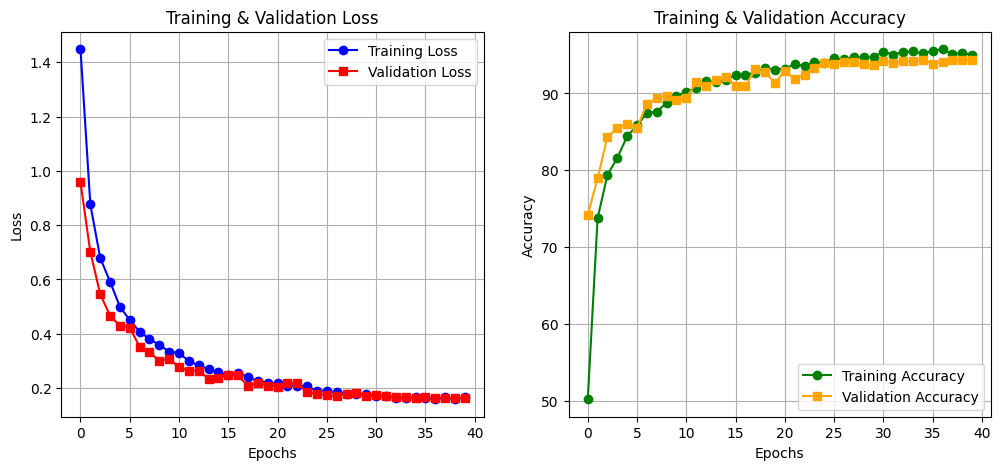


========== Evaluating Swin-tiny V1 on Validation Set ==========


Overall Accuracy: 94.39%
Overall Error Rate: 5.61%
F1-Score (Macro-Averaged): 94.38%
F1-Score (Weighted): 94.39%
Matthews Correlation Coefficient (MCC): 93.46%
Cohen’s Kappa Score: 93.45%
Top-1 Accuracy (%): 94.39%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.073764 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          89.93       86.81         88.34            98.33
 BRRI_28          94.81       96.24         95.52            99.17
 BRRI_29          88.11       91.97         90.00            97.98
 BRRI_34          94.89       98.48         96.65            99.17
 BRRI_50          95.52       96.24         95.88            99.29
 BRRI_74          98.73       95.68         97.18            99.76
    BR_5          98.52       95.68         97.08            99.76

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108

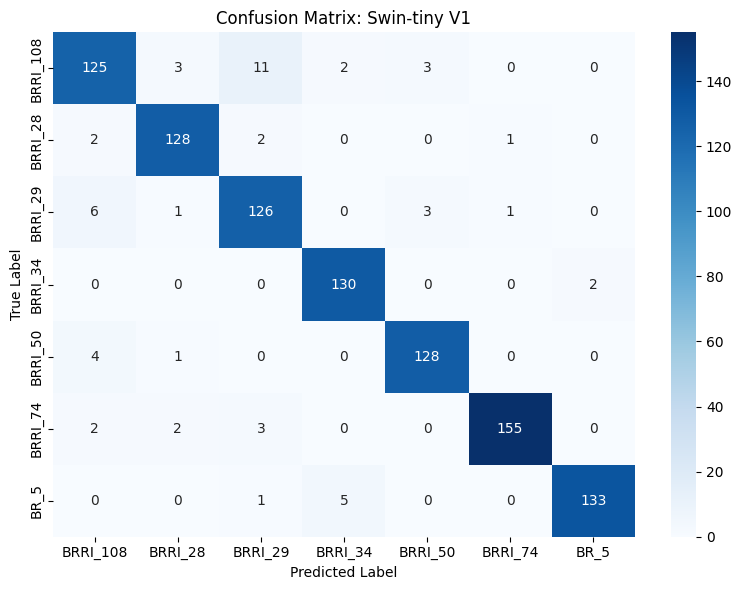

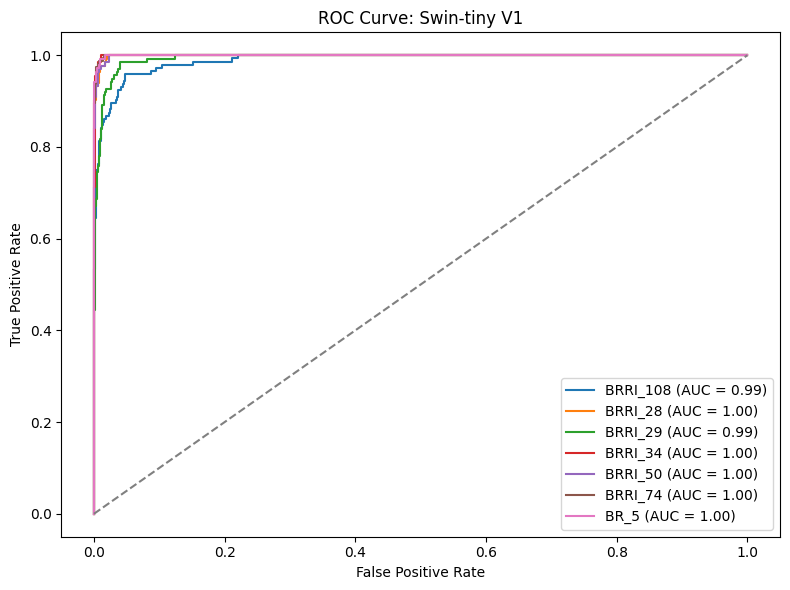

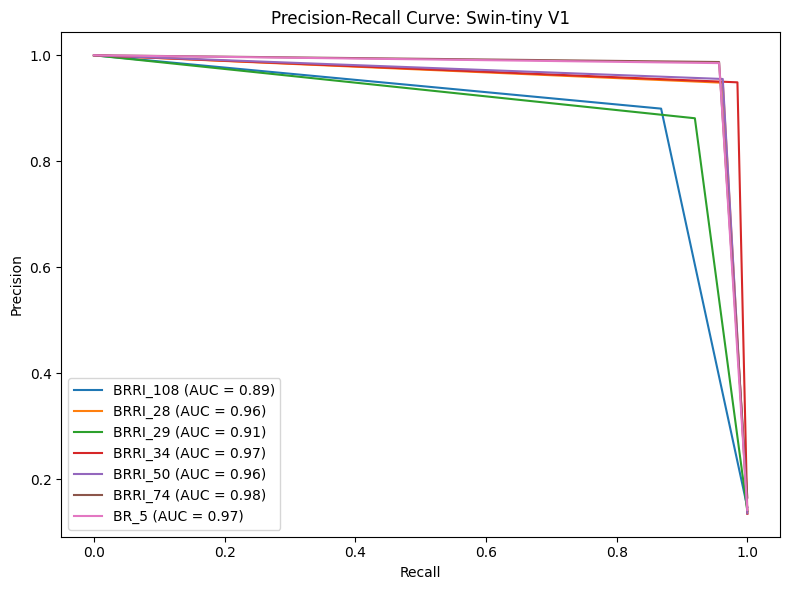


========== Evaluating Swin-tiny V1 on Tesing Set ==========


Overall Accuracy: 95.71%
Overall Error Rate: 4.29%
F1-Score (Macro-Averaged): 95.73%
F1-Score (Weighted): 95.65%
Matthews Correlation Coefficient (MCC): 95.02%
Cohen’s Kappa Score: 95.00%
Top-1 Accuracy (%): 95.71%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.074801 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          92.11       94.59         93.33            98.56
 BRRI_28          95.59      100.00         97.74            99.29
 BRRI_29          93.85       83.56         88.41            99.04
 BRRI_34          98.53       97.10         97.81            99.76
 BRRI_50          95.89       98.59         97.22            99.28
 BRRI_74          96.77       98.36         97.56            99.53
    BR_5          97.44       98.70         98.06            99.52

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108    

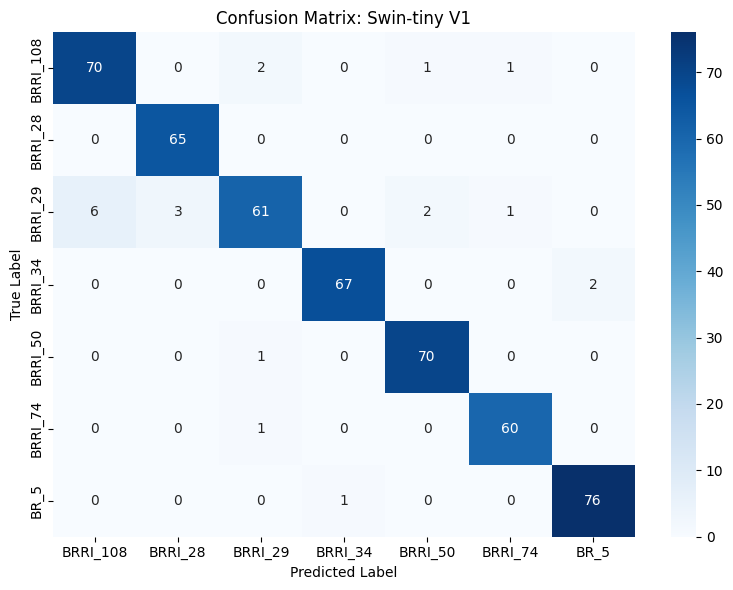

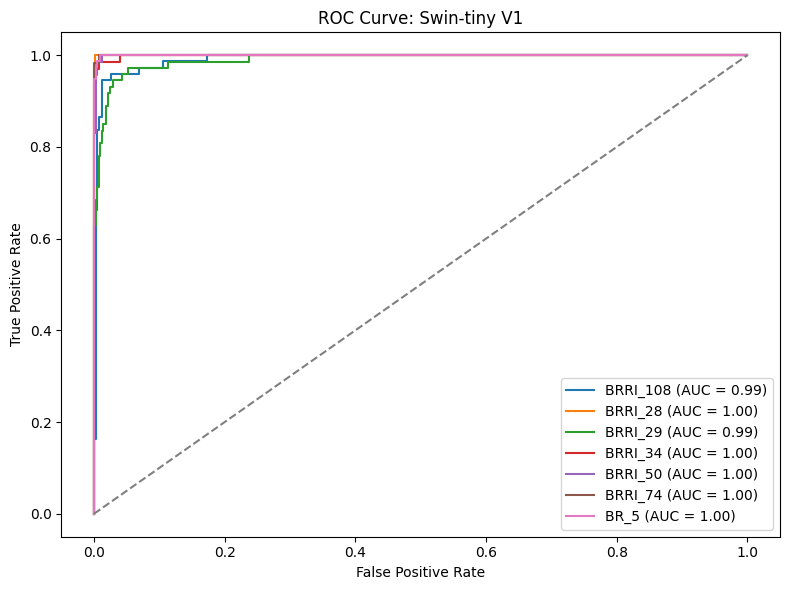

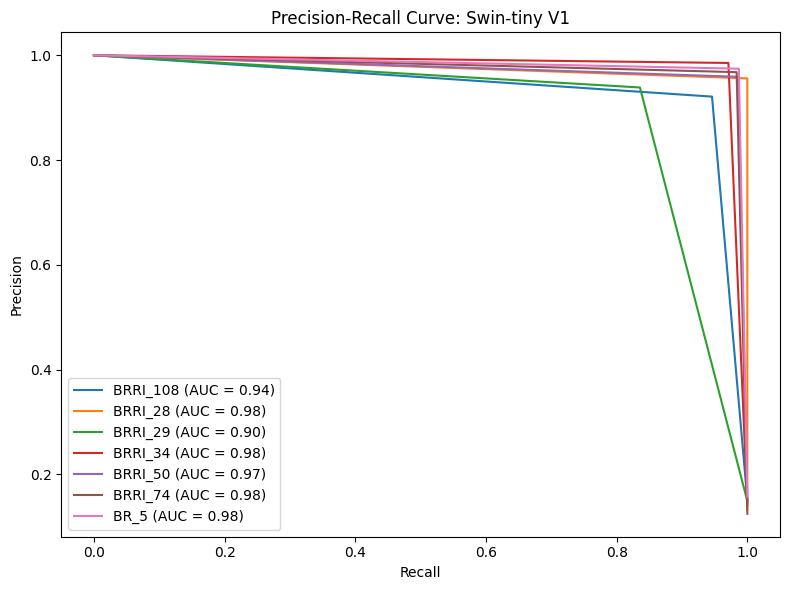

In [17]:
plotting(history_Swin)
metrics1 = evaluate_model(model_Swin, val_loader, class_names=dataset.classes, loader_name="Validation", model_name="Swin-tiny V1")
metrics1 = evaluate_model(model_Swin, test_loader, class_names=dataset.classes, loader_name="Tesing", model_name="Swin-tiny V1")

# DeiT-Small

In [19]:
import timm
import torch
import torch.nn as nn

model_DeitT = timm.create_model('deit_small_patch16_224', pretrained=True, num_classes=num_classes)

# Freeze all layers first
for param in model_DeitT.parameters():
    param.requires_grad = False

# Unfreeze input (patch embedding) layer
for param in model_DeitT.patch_embed.parameters():
    param.requires_grad = True

# Unfreeze output (classification head) layer
for param in model_DeitT.head.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_DeitT.to(device)

print(f"Model loaded, and moved to {device}")
print("Only input (patch_embed) and output (head) layers are trainable.")

import torch.optim.lr_scheduler as lr_scheduler

# Defining loss function
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model_DeitT.parameters(), lr=5e-4, weight_decay=0.05)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

Model loaded, and moved to cpu
Only input (patch_embed) and output (head) layers are trainable.


In [20]:
history_DeiT = train(
    model=model_DeitT,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=40,
    patience=40
)

Epoch 1/40: 100%|███████████████████████████████| 54/54 [04:36<00:00,  5.12s/it]


Epoch 1/40: Train Loss: 1.4700, Train Acc: 43.09% | Val Loss: 0.9960, Val Acc: 63.16%
Model improved. Best checkpoint saved.


Epoch 2/40: 100%|███████████████████████████████| 54/54 [04:58<00:00,  5.53s/it]


Epoch 2/40: Train Loss: 0.8620, Train Acc: 70.41% | Val Loss: 0.8144, Val Acc: 68.78%
Model improved. Best checkpoint saved.


Epoch 3/40: 100%|███████████████████████████████| 54/54 [05:20<00:00,  5.94s/it]


Epoch 3/40: Train Loss: 0.6221, Train Acc: 77.76% | Val Loss: 0.5718, Val Acc: 80.51%
Model improved. Best checkpoint saved.


Epoch 4/40: 100%|███████████████████████████████| 54/54 [06:03<00:00,  6.72s/it]


Epoch 4/40: Train Loss: 0.5274, Train Acc: 81.69% | Val Loss: 0.6300, Val Acc: 76.12%
No improvement. Early stopping counter: 1/40


Epoch 5/40: 100%|███████████████████████████████| 54/54 [06:36<00:00,  7.35s/it]


Epoch 5/40: Train Loss: 0.4113, Train Acc: 86.09% | Val Loss: 0.5242, Val Acc: 80.92%
Model improved. Best checkpoint saved.


Epoch 6/40: 100%|███████████████████████████████| 54/54 [05:43<00:00,  6.36s/it]


Epoch 6/40: Train Loss: 0.3600, Train Acc: 87.43% | Val Loss: 0.4114, Val Acc: 85.82%
Model improved. Best checkpoint saved.


Epoch 7/40: 100%|███████████████████████████████| 54/54 [06:33<00:00,  7.29s/it]


Epoch 7/40: Train Loss: 0.3501, Train Acc: 88.19% | Val Loss: 0.4451, Val Acc: 84.39%
No improvement. Early stopping counter: 1/40


Epoch 8/40: 100%|███████████████████████████████| 54/54 [06:20<00:00,  7.04s/it]


Epoch 8/40: Train Loss: 0.2637, Train Acc: 91.40% | Val Loss: 0.4202, Val Acc: 84.69%
No improvement. Early stopping counter: 2/40


Epoch 9/40: 100%|███████████████████████████████| 54/54 [06:12<00:00,  6.89s/it]


Epoch 9/40: Train Loss: 0.2032, Train Acc: 93.97% | Val Loss: 0.7409, Val Acc: 73.88%
No improvement. Early stopping counter: 3/40


Epoch 10/40: 100%|██████████████████████████████| 54/54 [06:10<00:00,  6.87s/it]


Epoch 10/40: Train Loss: 0.1780, Train Acc: 95.04% | Val Loss: 0.4312, Val Acc: 83.57%
No improvement. Early stopping counter: 4/40


Epoch 11/40: 100%|██████████████████████████████| 54/54 [06:29<00:00,  7.22s/it]


Epoch 11/40: Train Loss: 0.1366, Train Acc: 96.38% | Val Loss: 0.4168, Val Acc: 85.20%
No improvement. Early stopping counter: 5/40


Epoch 12/40: 100%|██████████████████████████████| 54/54 [06:42<00:00,  7.45s/it]


Epoch 12/40: Train Loss: 0.1510, Train Acc: 95.80% | Val Loss: 0.4473, Val Acc: 83.57%
No improvement. Early stopping counter: 6/40


Epoch 13/40: 100%|██████████████████████████████| 54/54 [06:31<00:00,  7.24s/it]


Epoch 13/40: Train Loss: 0.1458, Train Acc: 95.60% | Val Loss: 0.4086, Val Acc: 85.61%
Model improved. Best checkpoint saved.


Epoch 14/40: 100%|██████████████████████████████| 54/54 [05:42<00:00,  6.35s/it]


Epoch 14/40: Train Loss: 0.0992, Train Acc: 98.10% | Val Loss: 0.3691, Val Acc: 86.73%
Model improved. Best checkpoint saved.


Epoch 15/40: 100%|██████████████████████████████| 54/54 [05:34<00:00,  6.19s/it]


Epoch 15/40: Train Loss: 0.0599, Train Acc: 99.15% | Val Loss: 0.3919, Val Acc: 86.43%
No improvement. Early stopping counter: 1/40


Epoch 16/40: 100%|██████████████████████████████| 54/54 [05:34<00:00,  6.19s/it]


Epoch 16/40: Train Loss: 0.0531, Train Acc: 99.21% | Val Loss: 0.3798, Val Acc: 86.33%
No improvement. Early stopping counter: 2/40


Epoch 17/40: 100%|██████████████████████████████| 54/54 [05:59<00:00,  6.67s/it]


Epoch 17/40: Train Loss: 0.0317, Train Acc: 99.83% | Val Loss: 0.3351, Val Acc: 87.65%
Model improved. Best checkpoint saved.


Epoch 18/40: 100%|██████████████████████████████| 54/54 [06:09<00:00,  6.84s/it]


Epoch 18/40: Train Loss: 0.0173, Train Acc: 100.00% | Val Loss: 0.3394, Val Acc: 88.06%
No improvement. Early stopping counter: 1/40


Epoch 19/40: 100%|██████████████████████████████| 54/54 [06:16<00:00,  6.97s/it]


Epoch 19/40: Train Loss: 0.0124, Train Acc: 100.00% | Val Loss: 0.3352, Val Acc: 88.16%
No improvement. Early stopping counter: 2/40


Epoch 20/40: 100%|██████████████████████████████| 54/54 [06:37<00:00,  7.36s/it]


Epoch 20/40: Train Loss: 0.0104, Train Acc: 100.00% | Val Loss: 0.3346, Val Acc: 88.37%
Model improved. Best checkpoint saved.


Epoch 21/40: 100%|██████████████████████████████| 54/54 [07:19<00:00,  8.14s/it]


Epoch 21/40: Train Loss: 0.0092, Train Acc: 100.00% | Val Loss: 0.3373, Val Acc: 87.96%
No improvement. Early stopping counter: 1/40


Epoch 22/40: 100%|██████████████████████████████| 54/54 [07:35<00:00,  8.43s/it]


Epoch 22/40: Train Loss: 0.0082, Train Acc: 100.00% | Val Loss: 0.3352, Val Acc: 88.06%
No improvement. Early stopping counter: 2/40


Epoch 23/40: 100%|██████████████████████████████| 54/54 [07:58<00:00,  8.87s/it]


Epoch 23/40: Train Loss: 0.0076, Train Acc: 100.00% | Val Loss: 0.3429, Val Acc: 87.55%
No improvement. Early stopping counter: 3/40


Epoch 24/40: 100%|██████████████████████████████| 54/54 [08:10<00:00,  9.08s/it]


Epoch 24/40: Train Loss: 0.0071, Train Acc: 100.00% | Val Loss: 0.3364, Val Acc: 88.37%
No improvement. Early stopping counter: 4/40


Epoch 25/40: 100%|██████████████████████████████| 54/54 [07:44<00:00,  8.60s/it]


Epoch 25/40: Train Loss: 0.0066, Train Acc: 100.00% | Val Loss: 0.3460, Val Acc: 87.76%
No improvement. Early stopping counter: 5/40


Epoch 26/40: 100%|██████████████████████████████| 54/54 [07:01<00:00,  7.81s/it]


Epoch 26/40: Train Loss: 0.0062, Train Acc: 100.00% | Val Loss: 0.3461, Val Acc: 87.86%
No improvement. Early stopping counter: 6/40


Epoch 27/40: 100%|██████████████████████████████| 54/54 [06:15<00:00,  6.96s/it]


Epoch 27/40: Train Loss: 0.0059, Train Acc: 100.00% | Val Loss: 0.3456, Val Acc: 88.06%
No improvement. Early stopping counter: 7/40


Epoch 28/40: 100%|██████████████████████████████| 54/54 [06:01<00:00,  6.70s/it]


Epoch 28/40: Train Loss: 0.0057, Train Acc: 100.00% | Val Loss: 0.3511, Val Acc: 87.76%
No improvement. Early stopping counter: 8/40


Epoch 29/40: 100%|██████████████████████████████| 54/54 [07:26<00:00,  8.27s/it]


Epoch 29/40: Train Loss: 0.0055, Train Acc: 100.00% | Val Loss: 0.3513, Val Acc: 87.55%
No improvement. Early stopping counter: 9/40


Epoch 30/40: 100%|██████████████████████████████| 54/54 [08:07<00:00,  9.03s/it]


Epoch 30/40: Train Loss: 0.0053, Train Acc: 100.00% | Val Loss: 0.3476, Val Acc: 88.16%
No improvement. Early stopping counter: 10/40


Epoch 31/40: 100%|██████████████████████████████| 54/54 [07:59<00:00,  8.87s/it]


Epoch 31/40: Train Loss: 0.0051, Train Acc: 100.00% | Val Loss: 0.3502, Val Acc: 87.96%
No improvement. Early stopping counter: 11/40


Epoch 32/40: 100%|██████████████████████████████| 54/54 [06:21<00:00,  7.07s/it]


Epoch 32/40: Train Loss: 0.0050, Train Acc: 100.00% | Val Loss: 0.3526, Val Acc: 87.96%
No improvement. Early stopping counter: 12/40


Epoch 33/40: 100%|██████████████████████████████| 54/54 [06:47<00:00,  7.54s/it]


Epoch 33/40: Train Loss: 0.0049, Train Acc: 100.00% | Val Loss: 0.3526, Val Acc: 87.76%
No improvement. Early stopping counter: 13/40


Epoch 34/40: 100%|██████████████████████████████| 54/54 [08:01<00:00,  8.92s/it]


Epoch 34/40: Train Loss: 0.0048, Train Acc: 100.00% | Val Loss: 0.3518, Val Acc: 87.96%
No improvement. Early stopping counter: 14/40


Epoch 35/40: 100%|██████████████████████████████| 54/54 [06:54<00:00,  7.67s/it]


Epoch 35/40: Train Loss: 0.0047, Train Acc: 100.00% | Val Loss: 0.3524, Val Acc: 87.96%
No improvement. Early stopping counter: 15/40


Epoch 36/40: 100%|██████████████████████████████| 54/54 [06:13<00:00,  6.92s/it]


Epoch 36/40: Train Loss: 0.0047, Train Acc: 100.00% | Val Loss: 0.3526, Val Acc: 87.86%
No improvement. Early stopping counter: 16/40


Epoch 37/40: 100%|██████████████████████████████| 54/54 [06:02<00:00,  6.72s/it]


Epoch 37/40: Train Loss: 0.0046, Train Acc: 100.00% | Val Loss: 0.3530, Val Acc: 88.06%
No improvement. Early stopping counter: 17/40


Epoch 38/40: 100%|██████████████████████████████| 54/54 [06:07<00:00,  6.81s/it]


Epoch 38/40: Train Loss: 0.0046, Train Acc: 100.00% | Val Loss: 0.3529, Val Acc: 87.96%
No improvement. Early stopping counter: 18/40


Epoch 39/40: 100%|██████████████████████████████| 54/54 [04:55<00:00,  5.48s/it]


Epoch 39/40: Train Loss: 0.0046, Train Acc: 100.00% | Val Loss: 0.3529, Val Acc: 87.96%
No improvement. Early stopping counter: 19/40


Epoch 40/40: 100%|██████████████████████████████| 54/54 [05:19<00:00,  5.92s/it]


Epoch 40/40: Train Loss: 0.0046, Train Acc: 100.00% | Val Loss: 0.3529, Val Acc: 87.96%
No improvement. Early stopping counter: 20/40


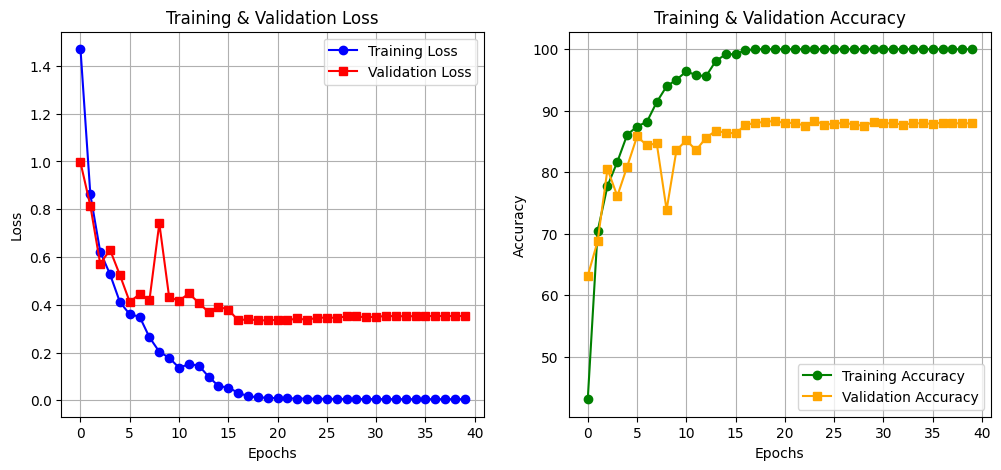


========== Evaluating DeiT-Small V1 on Validation Set ==========


Overall Accuracy: 87.96%
Overall Error Rate: 12.04%
F1-Score (Macro-Averaged): 87.93%
F1-Score (Weighted): 87.94%
Matthews Correlation Coefficient (MCC): 85.96%
Cohen’s Kappa Score: 85.95%
Top-1 Accuracy (%): 87.96%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.024457 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          79.14       76.39         77.74            96.53
 BRRI_28          86.62       92.48         89.45            97.76
 BRRI_29          85.82       88.32         87.05            97.63
 BRRI_34          87.60       85.61         86.59            98.11
 BRRI_50          91.97       94.74         93.33            98.70
 BRRI_74          95.33       88.27         91.67            99.14
    BR_5          88.73       90.65         89.68            98.10

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_1

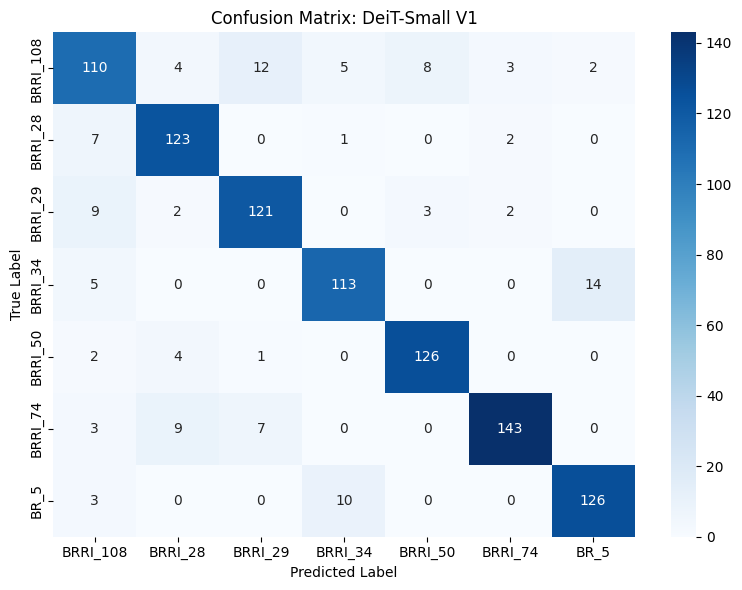

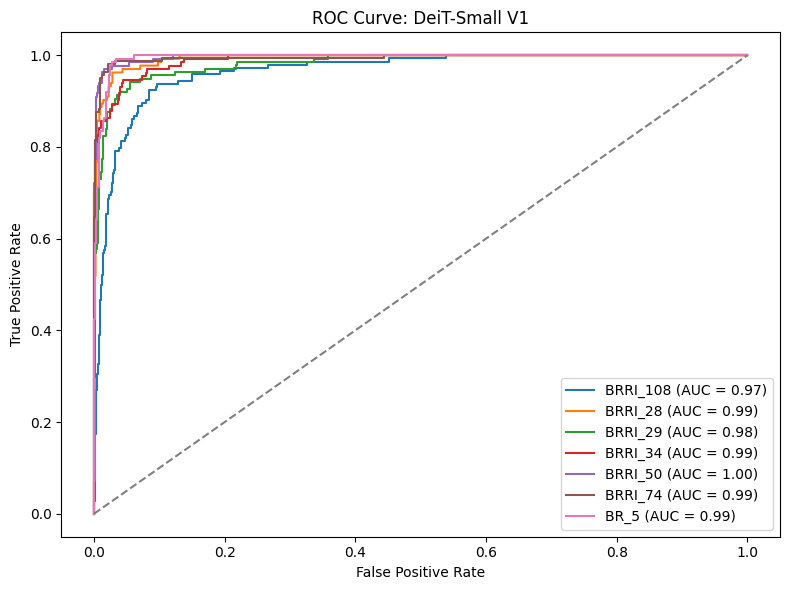

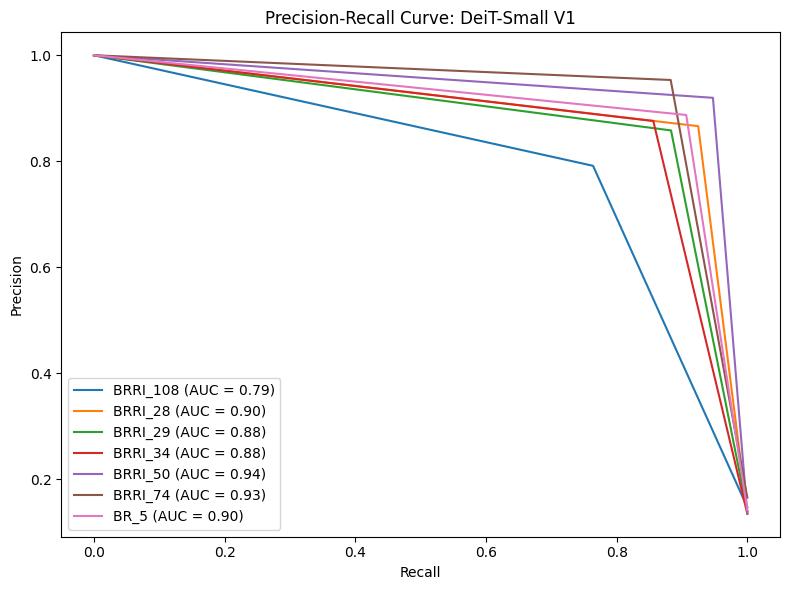


========== Evaluating DeiT-Small V1 on Tesing Set ==========


Overall Accuracy: 84.90%
Overall Error Rate: 15.10%
F1-Score (Macro-Averaged): 85.09%
F1-Score (Weighted): 84.86%
Matthews Correlation Coefficient (MCC): 82.39%
Cohen’s Kappa Score: 82.37%
Top-1 Accuracy (%): 84.90%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.023461 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          82.35       75.68         78.87            97.12
 BRRI_28          84.72       93.85         89.05            97.41
 BRRI_29          79.17       78.08         78.62            96.40
 BRRI_34          80.28       82.61         81.43            96.67
 BRRI_50          91.43       90.14         90.78            98.57
 BRRI_74          94.74       88.52         91.53            99.30
    BR_5          83.75       87.01         85.35            96.85

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108  

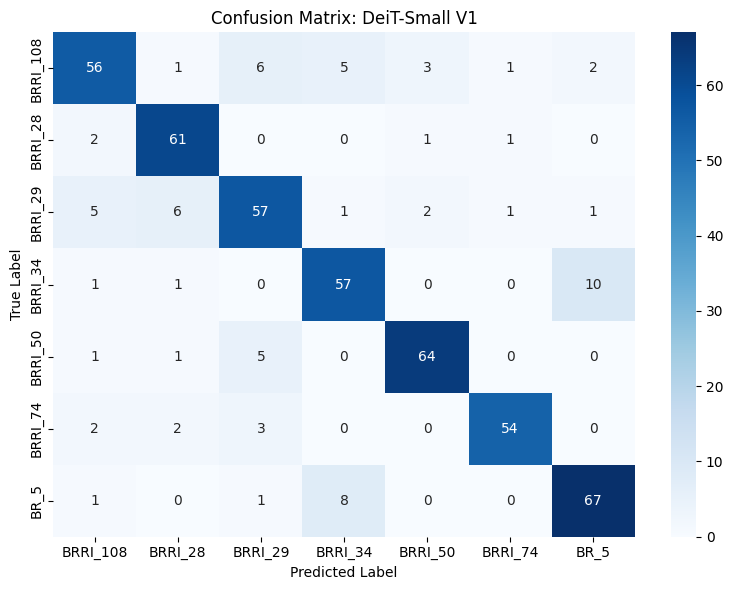

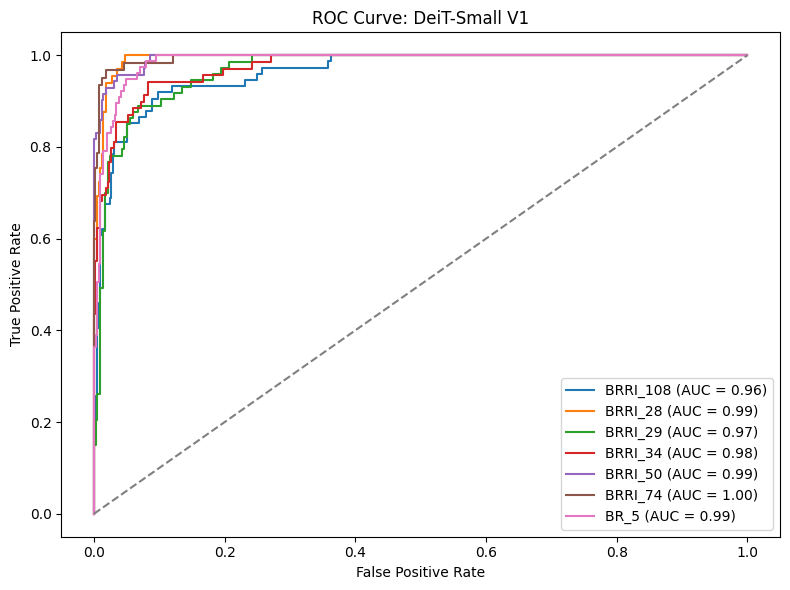

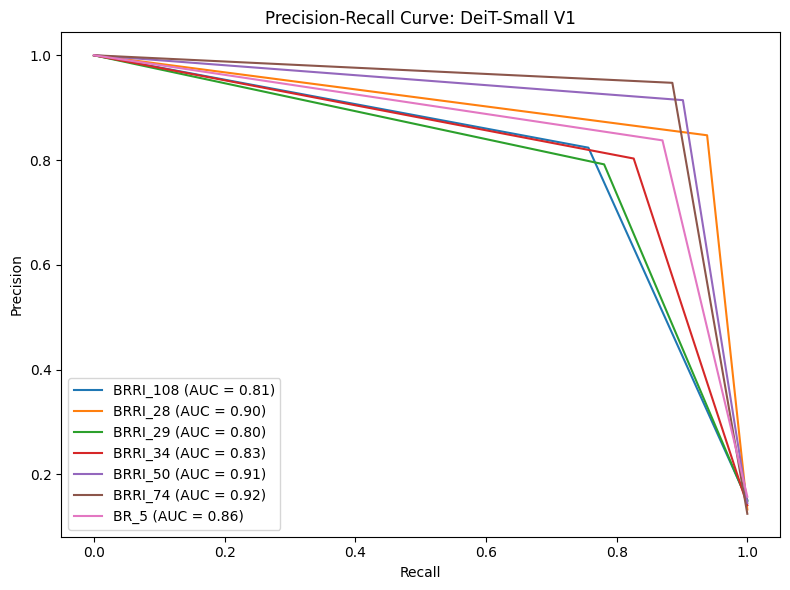

In [21]:
plotting(history_DeiT)
metrics2 = evaluate_model(model_DeitT, val_loader, class_names=dataset.classes, loader_name="Validation", model_name="DeiT-Small V1")
metrics2 = evaluate_model(model_DeitT, test_loader, class_names=dataset.classes, loader_name="Tesing", model_name="DeiT-Small V1")

# MobileViT-Small

In [22]:
model_MobileViT = timm.create_model('mobilevit_s', pretrained=True, num_classes=num_classes)

for param in model_MobileViT.parameters():
    param.requires_grad = False

# Unfreeze the input layer (stem)
for param in model_MobileViT.stem.parameters():
    param.requires_grad = True

# Unfreeze the output layer (classification head)
for param in model_MobileViT.head.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_MobileViT.to(device)

print(f"Model loaded and moved to {device}")
print("Only the input (stem) and output (head) layers are trainable.")

import torch.optim.lr_scheduler as lr_scheduler

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer (only trainable params will be updated: stem + head)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_MobileViT.parameters()), lr=5e-4, weight_decay=0.05)

# Cosine annealing scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

Model loaded and moved to cpu
Only the input (stem) and output (head) layers are trainable.


In [23]:
history_MobileViT = train(
    model=model_MobileViT,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=40,
    patience=40
)

Epoch 1/40: 100%|███████████████████████████████| 54/54 [15:01<00:00, 16.70s/it]


Epoch 1/40: Train Loss: 1.7997, Train Acc: 48.98% | Val Loss: 1.7431, Val Acc: 48.98%
Model improved. Best checkpoint saved.


Epoch 2/40: 100%|███████████████████████████████| 54/54 [26:05<00:00, 28.98s/it]


Epoch 2/40: Train Loss: 1.5162, Train Acc: 61.34% | Val Loss: 1.5283, Val Acc: 56.94%
Model improved. Best checkpoint saved.


Epoch 3/40: 100%|███████████████████████████████| 54/54 [26:30<00:00, 29.46s/it]


Epoch 3/40: Train Loss: 1.3029, Train Acc: 66.33% | Val Loss: 1.4772, Val Acc: 57.65%
Model improved. Best checkpoint saved.


Epoch 4/40: 100%|███████████████████████████████| 54/54 [30:12<00:00, 33.57s/it]


Epoch 4/40: Train Loss: 1.1692, Train Acc: 66.97% | Val Loss: 1.3213, Val Acc: 58.47%
Model improved. Best checkpoint saved.


Epoch 5/40: 100%|███████████████████████████████| 54/54 [32:41<00:00, 36.32s/it]


Epoch 5/40: Train Loss: 1.0539, Train Acc: 70.23% | Val Loss: 1.4888, Val Acc: 53.16%
No improvement. Early stopping counter: 1/40


Epoch 6/40: 100%|███████████████████████████████| 54/54 [26:31<00:00, 29.48s/it]


Epoch 6/40: Train Loss: 0.9810, Train Acc: 71.87% | Val Loss: 1.3798, Val Acc: 56.84%
No improvement. Early stopping counter: 2/40


Epoch 7/40: 100%|███████████████████████████████| 54/54 [29:20<00:00, 32.60s/it]


Epoch 7/40: Train Loss: 0.9176, Train Acc: 73.99% | Val Loss: 1.2177, Val Acc: 57.86%
Model improved. Best checkpoint saved.


Epoch 8/40: 100%|███████████████████████████████| 54/54 [34:45<00:00, 38.62s/it]


Epoch 8/40: Train Loss: 0.8727, Train Acc: 73.85% | Val Loss: 1.1091, Val Acc: 66.43%
Model improved. Best checkpoint saved.


Epoch 9/40: 100%|███████████████████████████████| 54/54 [21:11<00:00, 23.55s/it]


Epoch 9/40: Train Loss: 0.8293, Train Acc: 75.19% | Val Loss: 1.1359, Val Acc: 63.06%
No improvement. Early stopping counter: 1/40


Epoch 10/40: 100%|██████████████████████████████| 54/54 [20:50<00:00, 23.15s/it]


Epoch 10/40: Train Loss: 0.7992, Train Acc: 75.95% | Val Loss: 1.0639, Val Acc: 65.00%
Model improved. Best checkpoint saved.


Epoch 11/40: 100%|██████████████████████████████| 54/54 [22:01<00:00, 24.48s/it]


Epoch 11/40: Train Loss: 0.7726, Train Acc: 77.32% | Val Loss: 1.0553, Val Acc: 66.53%
Model improved. Best checkpoint saved.


Epoch 12/40: 100%|██████████████████████████████| 54/54 [17:58<00:00, 19.98s/it]


Epoch 12/40: Train Loss: 0.7466, Train Acc: 77.58% | Val Loss: 1.2159, Val Acc: 55.41%
No improvement. Early stopping counter: 1/40


Epoch 13/40: 100%|██████████████████████████████| 54/54 [17:07<00:00, 19.03s/it]


Epoch 13/40: Train Loss: 0.7274, Train Acc: 77.55% | Val Loss: 1.1178, Val Acc: 60.10%
No improvement. Early stopping counter: 2/40


Epoch 14/40: 100%|██████████████████████████████| 54/54 [17:06<00:00, 19.01s/it]


Epoch 14/40: Train Loss: 0.7039, Train Acc: 78.95% | Val Loss: 1.1368, Val Acc: 56.94%
No improvement. Early stopping counter: 3/40


Epoch 15/40: 100%|██████████████████████████████| 54/54 [17:06<00:00, 19.01s/it]


Epoch 15/40: Train Loss: 0.6890, Train Acc: 79.04% | Val Loss: 0.7851, Val Acc: 74.59%
Model improved. Best checkpoint saved.


Epoch 16/40: 100%|██████████████████████████████| 54/54 [17:15<00:00, 19.17s/it]


Epoch 16/40: Train Loss: 0.6753, Train Acc: 79.85% | Val Loss: 0.9539, Val Acc: 68.57%
No improvement. Early stopping counter: 1/40


Epoch 17/40: 100%|██████████████████████████████| 54/54 [15:48<00:00, 17.57s/it]


Epoch 17/40: Train Loss: 0.6646, Train Acc: 79.50% | Val Loss: 0.9751, Val Acc: 65.71%
No improvement. Early stopping counter: 2/40


Epoch 18/40: 100%|██████████████████████████████| 54/54 [15:18<00:00, 17.01s/it]


Epoch 18/40: Train Loss: 0.6426, Train Acc: 80.64% | Val Loss: 1.0337, Val Acc: 63.67%
No improvement. Early stopping counter: 3/40


Epoch 19/40: 100%|██████████████████████████████| 54/54 [16:19<00:00, 18.13s/it]


Epoch 19/40: Train Loss: 0.6466, Train Acc: 79.65% | Val Loss: 0.9411, Val Acc: 67.86%
No improvement. Early stopping counter: 4/40


Epoch 20/40: 100%|██████████████████████████████| 54/54 [18:09<00:00, 20.18s/it]


Epoch 20/40: Train Loss: 0.6178, Train Acc: 80.99% | Val Loss: 1.0351, Val Acc: 62.65%
No improvement. Early stopping counter: 5/40


Epoch 21/40: 100%|██████████████████████████████| 54/54 [21:05<00:00, 23.43s/it]


Epoch 21/40: Train Loss: 0.6293, Train Acc: 80.47% | Val Loss: 0.8239, Val Acc: 70.31%
No improvement. Early stopping counter: 6/40


Epoch 22/40: 100%|██████████████████████████████| 54/54 [19:19<00:00, 21.47s/it]


Epoch 22/40: Train Loss: 0.6083, Train Acc: 81.28% | Val Loss: 0.7898, Val Acc: 72.96%
No improvement. Early stopping counter: 7/40


Epoch 23/40: 100%|██████████████████████████████| 54/54 [17:38<00:00, 19.60s/it]


Epoch 23/40: Train Loss: 0.6003, Train Acc: 81.69% | Val Loss: 1.1031, Val Acc: 59.29%
No improvement. Early stopping counter: 8/40


Epoch 24/40: 100%|██████████████████████████████| 54/54 [17:18<00:00, 19.22s/it]


Epoch 24/40: Train Loss: 0.5965, Train Acc: 81.46% | Val Loss: 0.8484, Val Acc: 68.88%
No improvement. Early stopping counter: 9/40


Epoch 25/40: 100%|██████████████████████████████| 54/54 [17:44<00:00, 19.71s/it]


Epoch 25/40: Train Loss: 0.5902, Train Acc: 81.92% | Val Loss: 0.7077, Val Acc: 75.61%
Model improved. Best checkpoint saved.


Epoch 26/40: 100%|██████████████████████████████| 54/54 [17:21<00:00, 19.29s/it]


Epoch 26/40: Train Loss: 0.5970, Train Acc: 81.95% | Val Loss: 0.7560, Val Acc: 74.08%
No improvement. Early stopping counter: 1/40


Epoch 27/40: 100%|██████████████████████████████| 54/54 [16:59<00:00, 18.88s/it]


Epoch 27/40: Train Loss: 0.5804, Train Acc: 81.92% | Val Loss: 0.7582, Val Acc: 73.57%
No improvement. Early stopping counter: 2/40


Epoch 28/40: 100%|██████████████████████████████| 54/54 [17:26<00:00, 19.39s/it]


Epoch 28/40: Train Loss: 0.5750, Train Acc: 81.90% | Val Loss: 0.7214, Val Acc: 75.31%
No improvement. Early stopping counter: 3/40


Epoch 29/40: 100%|██████████████████████████████| 54/54 [17:18<00:00, 19.23s/it]


Epoch 29/40: Train Loss: 0.5789, Train Acc: 82.51% | Val Loss: 0.6652, Val Acc: 77.45%
Model improved. Best checkpoint saved.


Epoch 30/40: 100%|██████████████████████████████| 54/54 [17:13<00:00, 19.13s/it]


Epoch 30/40: Train Loss: 0.5681, Train Acc: 82.77% | Val Loss: 0.8441, Val Acc: 69.90%
No improvement. Early stopping counter: 1/40


Epoch 31/40: 100%|██████████████████████████████| 54/54 [17:24<00:00, 19.34s/it]


Epoch 31/40: Train Loss: 0.5772, Train Acc: 81.49% | Val Loss: 0.7786, Val Acc: 73.98%
No improvement. Early stopping counter: 2/40


Epoch 32/40: 100%|██████████████████████████████| 54/54 [17:38<00:00, 19.59s/it]


Epoch 32/40: Train Loss: 0.5659, Train Acc: 82.36% | Val Loss: 0.8184, Val Acc: 69.29%
No improvement. Early stopping counter: 3/40


Epoch 33/40: 100%|██████████████████████████████| 54/54 [17:23<00:00, 19.32s/it]


Epoch 33/40: Train Loss: 0.5669, Train Acc: 81.57% | Val Loss: 0.6435, Val Acc: 77.96%
Model improved. Best checkpoint saved.


Epoch 34/40: 100%|██████████████████████████████| 54/54 [17:11<00:00, 19.11s/it]


Epoch 34/40: Train Loss: 0.5668, Train Acc: 82.24% | Val Loss: 0.6336, Val Acc: 78.47%
Model improved. Best checkpoint saved.


Epoch 35/40: 100%|██████████████████████████████| 54/54 [17:34<00:00, 19.52s/it]


Epoch 35/40: Train Loss: 0.5694, Train Acc: 82.65% | Val Loss: 0.6305, Val Acc: 77.86%
Model improved. Best checkpoint saved.


Epoch 36/40: 100%|██████████████████████████████| 54/54 [17:49<00:00, 19.81s/it]


Epoch 36/40: Train Loss: 0.5682, Train Acc: 82.19% | Val Loss: 0.6206, Val Acc: 78.06%
Model improved. Best checkpoint saved.


Epoch 37/40: 100%|██████████████████████████████| 54/54 [17:59<00:00, 20.00s/it]


Epoch 37/40: Train Loss: 0.5635, Train Acc: 82.48% | Val Loss: 0.6195, Val Acc: 78.67%
Model improved. Best checkpoint saved.


Epoch 38/40: 100%|██████████████████████████████| 54/54 [17:18<00:00, 19.23s/it]


Epoch 38/40: Train Loss: 0.5638, Train Acc: 82.74% | Val Loss: 0.6162, Val Acc: 78.88%
Model improved. Best checkpoint saved.


Epoch 39/40: 100%|██████████████████████████████| 54/54 [17:21<00:00, 19.30s/it]


Epoch 39/40: Train Loss: 0.5683, Train Acc: 82.59% | Val Loss: 0.6171, Val Acc: 78.78%
No improvement. Early stopping counter: 1/40


Epoch 40/40: 100%|██████████████████████████████| 54/54 [17:29<00:00, 19.44s/it]


Epoch 40/40: Train Loss: 0.5622, Train Acc: 83.00% | Val Loss: 0.6181, Val Acc: 78.47%
No improvement. Early stopping counter: 2/40


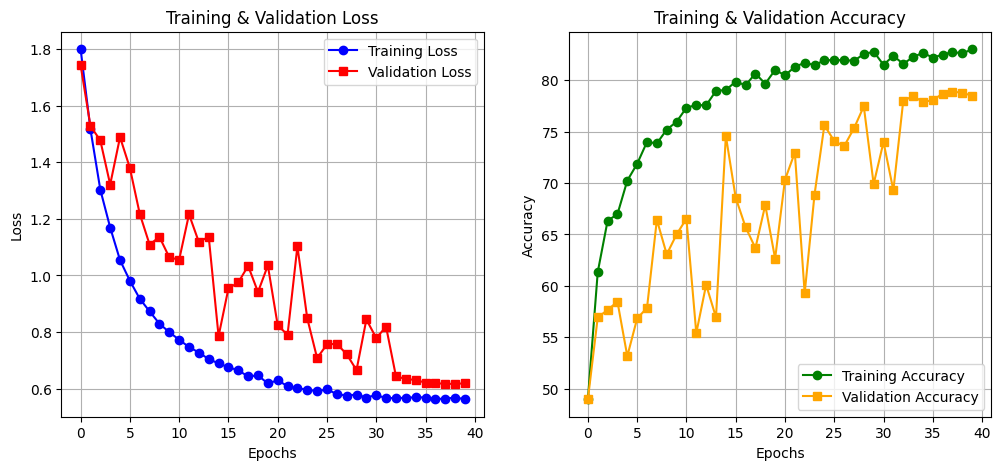


========== Evaluating MobileViT-Small V1 on Validation Set ==========


Overall Accuracy: 78.47%
Overall Error Rate: 21.53%
F1-Score (Macro-Averaged): 78.14%
F1-Score (Weighted): 78.21%
Matthews Correlation Coefficient (MCC): 74.96%
Cohen’s Kappa Score: 74.87%
Top-1 Accuracy (%): 78.47%
Top-5 Accuracy (%): 99.80%

Average Inference Time per Image: 0.098682 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          79.85       74.31         76.98            96.77
 BRRI_28          72.73       90.23         80.54            94.69
 BRRI_29          69.91       57.66         63.20            95.97
 BRRI_34          78.57       75.00         76.74            96.82
 BRRI_50          79.59       87.97         83.57            96.46
 BRRI_74          83.33       80.25         81.76            96.82
    BR_5          84.17       84.17         84.17            97.38

Class-Wise Sample Distribution:
   Class  Support (Samples)
BR

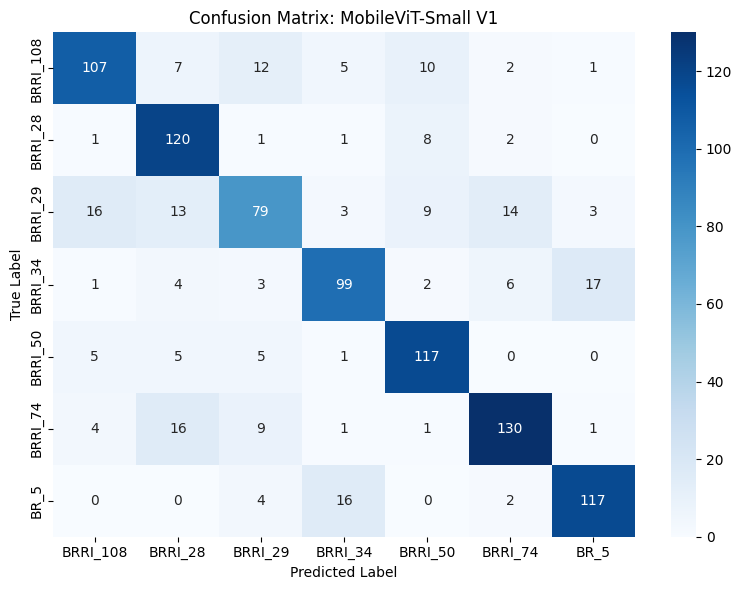

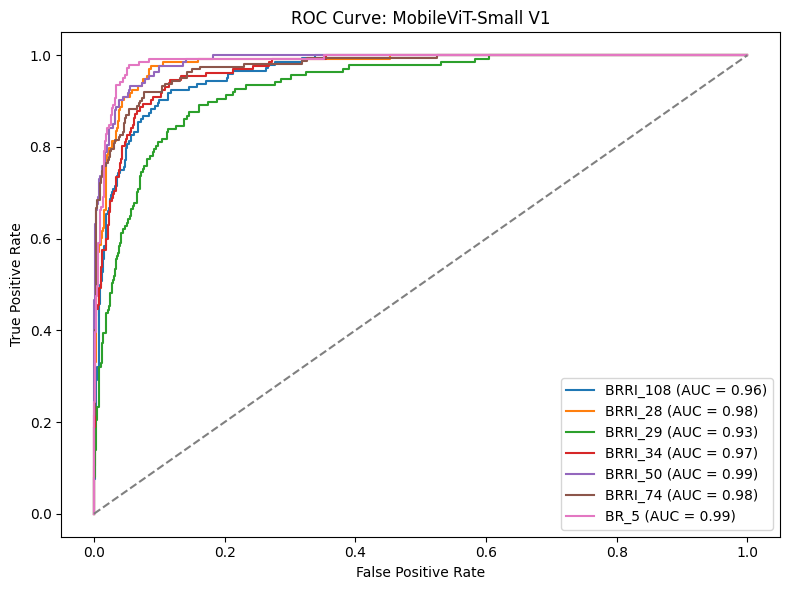

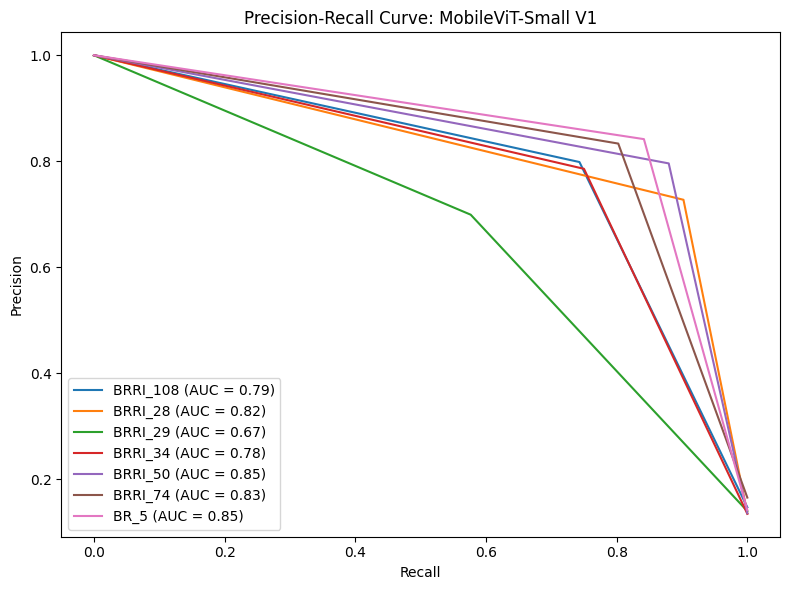


========== Evaluating MobileViT-Small V1 on Tesing Set ==========


Overall Accuracy: 80.20%
Overall Error Rate: 19.80%
F1-Score (Macro-Averaged): 80.03%
F1-Score (Weighted): 79.94%
Matthews Correlation Coefficient (MCC): 77.00%
Cohen’s Kappa Score: 76.90%
Top-1 Accuracy (%): 80.20%
Top-5 Accuracy (%): 99.80%

Average Inference Time per Image: 0.100590 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          80.56       78.38         79.45            96.63
 BRRI_28          74.07       92.31         82.19            95.06
 BRRI_29          74.14       58.90         65.65            96.40
 BRRI_34          76.06       78.26         77.14            95.96
 BRRI_50          83.12       90.14         86.49            96.90
 BRRI_74          87.50       80.33         83.76            98.37
    BR_5          86.67       84.42         85.53            97.58

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_1

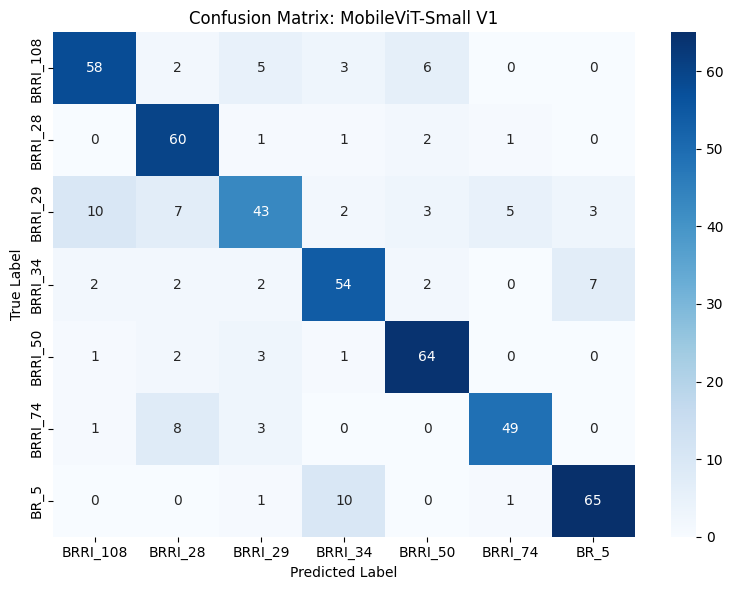

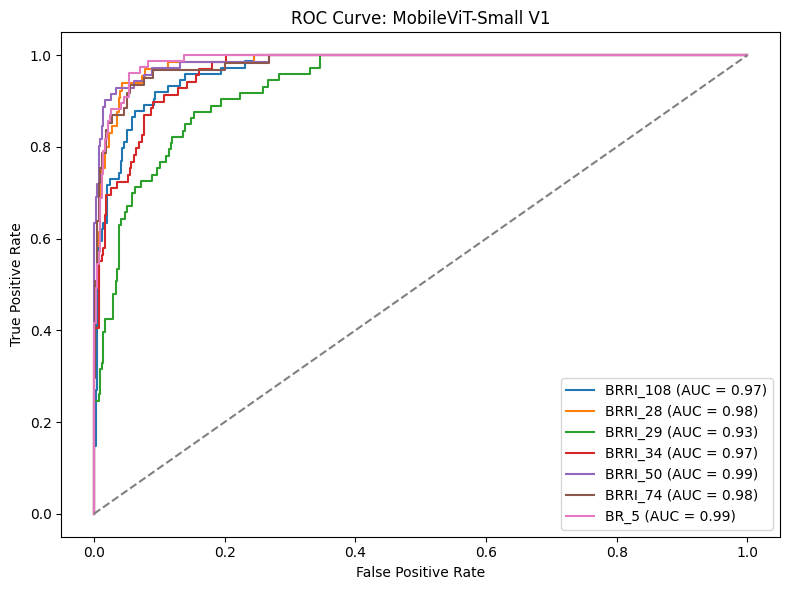

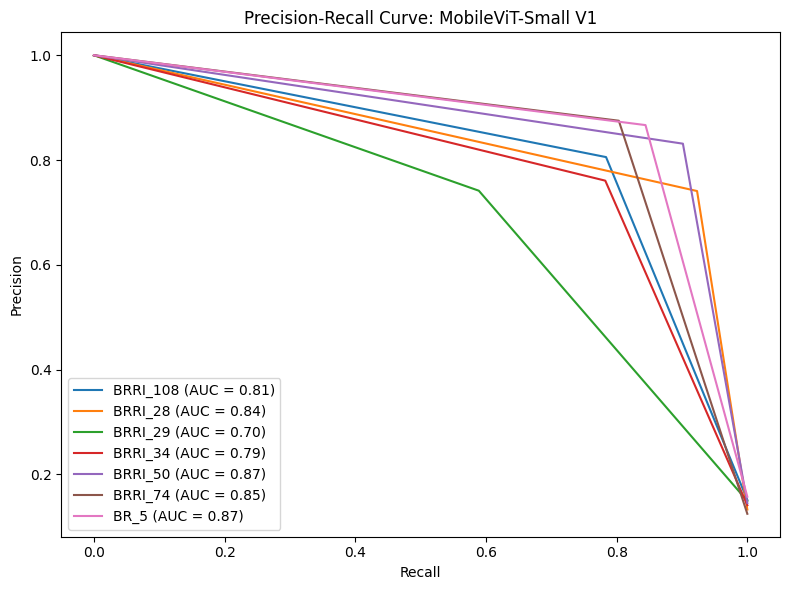

In [24]:
plotting(history_MobileViT)
metrics2 = evaluate_model(model_MobileViT, val_loader, class_names=dataset.classes, loader_name="Validation", model_name="MobileViT-Small V1")
metrics2 = evaluate_model(model_MobileViT, test_loader, class_names=dataset.classes, loader_name="Tesing", model_name="MobileViT-Small V1")

In [25]:
dataset

Dataset ImageFolder
    Number of datapoints: 4900
    Root location: /Users/tahfimibnkhan/Desktop/DATASET/FINAL/AUGMENTED_DATA(without random erasing)
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )